# Analyzing the frequency components of a signal with a Fast Fourier Transform

Credits to https://ipython-books.github.io/chapter-10-signal-processing/

In [1]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('~/faktion.com/products-&-solutions - Documents/Faktion Academy/School of AI - mini course on sensor data/belgian_weather.csv',
                  na_values=(-9999),
                  parse_dates=['DATE'])

In [3]:
df.head()

,STATION,NAME,DATE,TAVG,TMAX,TMIN
0,BE000006447,"UCCLE, BE",1905-01-01,NaN,-4.1,-8.3
1,BE000006447,"UCCLE, BE",1905-01-02,NaN,-4.0,-11.2
2,BE000006447,"UCCLE, BE",1905-01-03,NaN,2.1,-8.7
3,BE000006447,"UCCLE, BE",1905-01-04,NaN,5.9,-6.3
4,BE000006447,"UCCLE, BE",1905-01-05,NaN,6.2,1.9


There are multiple stations in here, so we take the average of them per day

In [4]:
df_avg = df[['TMAX', 'DATE']].dropna().groupby('DATE').mean()

In [5]:
df_avg.head()

,TMAX
DATE,
1905-01-01,-4.1
1905-01-02,-4.0
1905-01-03,2.1
1905-01-04,5.9
1905-01-05,6.2


### Plot it

Text(0, 0.5, 'Mean temperature')

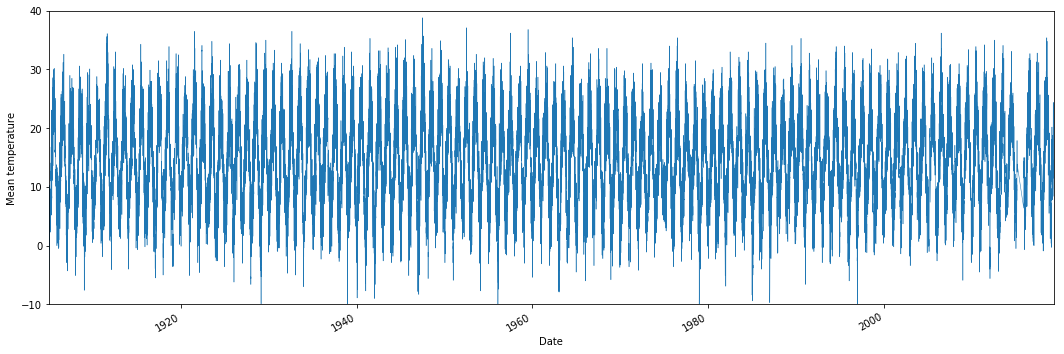

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
df_avg['TMAX'].plot(ax=ax, lw=.5)
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')

Check gaps in data

In [7]:
df_avg["year"] = df_avg.index.year
yearly_counts = df_avg.groupby('year')['TMAX'].count()
yearly_counts[yearly_counts<365]

year
2000    299
2001    308
2002    312
2003    312
2004    294
2005    227
2006    299
2007    336
2008    316
2009    330
2010    324
2011    322
2012    323
2013    324
2014    335
2015     74
2016    291
2017    309
2018    257
2019     87
Name: TMAX, dtype: int64

In [8]:
df_avg = df_avg.query("year < 2000")

### Analyze frequencies

In [9]:
temp_fft = sp.fftpack.fft(df_avg['TMAX'])

In [10]:
temp_psd = np.abs(temp_fft) ** 2

In [11]:
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 365)

In [12]:
# Keep positive frequencies only
i = fftfreq > 0

In [13]:
max_amp = np.max(np.abs(temp_fft[i]))
max_amp_idx = np.where(np.abs(temp_fft)==max_amp)[0][0]

max_psd = temp_psd[max_amp_idx]
max_freq = fftfreq[max_amp_idx]
print("Index of max amplitude", max_amp_idx)
print("Highest psd with non-zero frequency is ", max_psd)
print("Frequency with highest PSD with non-zero frequency is ", max_freq)


Index of max amplitude 95
Highest psd with non-zero frequency is  25369452438.636044
Frequency with highest PSD with non-zero frequency is  0.9993371375871807


Text(0, 0.5, 'Power Spectral Density (dB)')

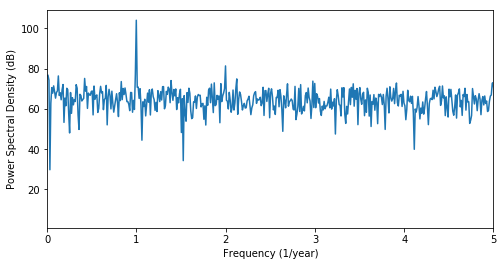

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.plot(fftfreq[i], temp_psd[i])
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('Power Spectral Density (dB)')

Perform an inverse FFT to convert the modified Fourier transform back to the temporal domain. This way, we recover a signal that mainly contains the fundamental frequency, as shown in the following figure:

In [31]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis = 0 * temp_fft_bis

# Add a0 = constant
temp_fft_bis[0]= temp_fft[0]

# add a_max = coefficient with max amplitude
temp_fft_bis[max_amp_idx] = temp_fft[max_amp_idx]

if False: # Add other coefficients
    mask = np.abs(fftfreq)<1
    temp_fft_bis[mask] = temp_fft[mask]


In [33]:
df_avg['F1'] = np.real(sp.fftpack.ifft(temp_fft_bis))

Text(0, 0.5, 'Mean temperature')

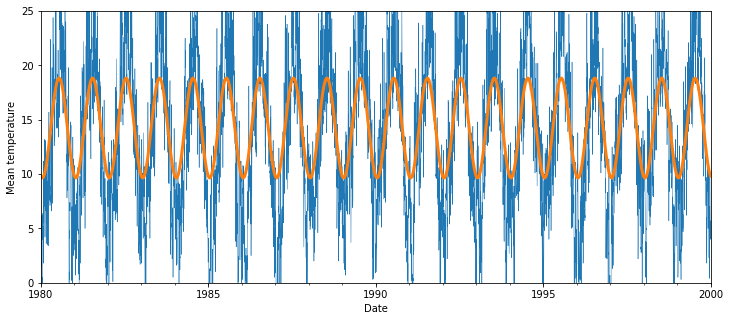

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df_avg['TMAX'].plot(ax=ax, lw=.5)
df_avg['F1'].plot(ax=ax, lw=3)
ax.set_xlim(datetime.date(1980, 1, 1),
            datetime.date(2000, 1, 1))
ax.set_ylim(-0, 25)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')